In [60]:
import os 
from collections import Counter 
import spacy
from PIL import Image
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 


import pandas as pd 
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence 
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms 

In [ ]:
DATA_PATH = "/kaggle/input/flickr8k"
CAPTION_FILE = "/kaggle/input/flickr8k/captions.txt"

In [4]:

df = pd.read_csv(CAPTION_FILE)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


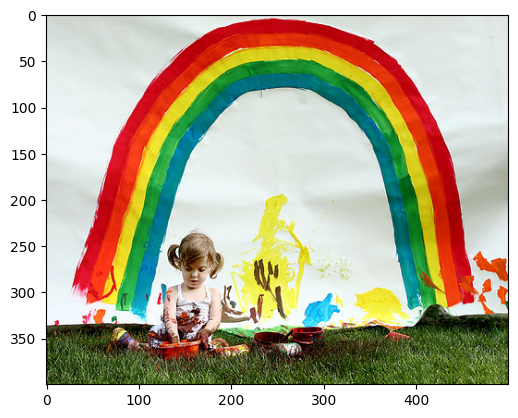

Caption: A little girl is sitting in front of a large painted rainbow .
Caption: A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
Caption: There is a girl with pigtails sitting in front of a rainbow painting .
Caption: Young girl with pigtails painting outside in the grass .
Caption: A man lays on a bench while his dog sits by him .


In [41]:
# Plot some images 
data_idx = 11 
image_path = os.path.join(DATA_PATH, "Images", df.iloc[data_idx, 0])
img = mpimg.imread(image_path)
plt.imshow(img)
plt.show();

for i in range(data_idx,data_idx+5):
    print("Caption:",df.iloc[i,1])

In [11]:
spacy_eng = spacy.load('en_core_web_sm')

In [13]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4 # skip 3 pre-defined 
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
                
                if frequencies[word] >= self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        "transform text to sentence index"
        tokenized_text = self.tokenize(text)
        
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]  

In [14]:
# test 
v = Vocabulary(freq_threshold=1)


v.build_vocab(["This is a good place to find a city"])
print(v.stoi)
print(v.numericalize("This is a good place to find a city here!!"))

{'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'this': 4, 'is': 5, 'a': 11, 'good': 7, 'place': 8, 'to': 9, 'find': 10, 'city': 12}
[4, 5, 11, 7, 8, 9, 10, 11, 12, 3, 3, 3]


In [22]:
class FlickrDataset(Dataset):
    def __init__(
        self,
        data_dir,
        caption_file, 
        transform = None,
        freq_threshold = 5
    ):
        self.data_dir = data_dir
        self.df = pd.read_csv(caption_file)
        self.transform = transform 
        
        self.imgs = self.df['image']
        self.captions = self.df['caption']
        
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())
    
    def __getitem__(self, idx):
        caption = self.captions[idx]
        img_name = self.imgs[idx]
        img_location = os.path.join(self.data_dir, 'Images', img_name)
        img = Image.open(img_location).convert("RGB")
        
        # apply the transformation to the image 
        if self.transform is not None:
            img = self.transform(img)
        
        # numericalize the caption text 
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        
        return img, torch.tensor(caption_vec)
    
    def __len__(self):
        return len(self.imgs)

In [32]:
# define the transforms 
train_transform = transforms.Compose([
    transforms.Resize(226),
    transforms.RandomCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
])

In [24]:
def show_image(inp, title = None):
    inp = inp.numpy().transpose((1,2,0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    
    plt.pause(0.001)

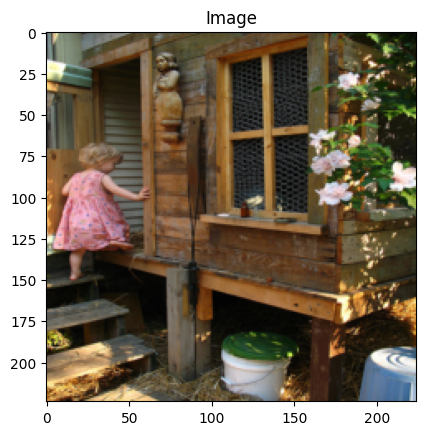

Token: tensor([     1, 457656, 457182, 457646, 457656, 457612, 456374, 457620, 457658,
        457635, 457656, 455820, 457479, 410334, 457646, 457194,      3, 452922,
        457660,      2])
Sentence:
['<SOS>', 'a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a', 'set', 'of', 'stairs', 'in', 'an', '<UNK>', 'way', '.', '<EOS>']


In [26]:
#testing the dataset class
dataset =  FlickrDataset(
    data_dir = DATA_PATH,
    caption_file = CAPTION_FILE,
    transform=train_transform
)



img, caps = dataset[0]
show_image(img,"Image")
print("Token:",caps)
print("Sentence:")
print([dataset.vocab.itos[token] for token in caps.tolist()])

In [27]:
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.pad_idx = pad_idx
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs,dim=0)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        return imgs,targets

In [28]:
BATCH_SIZE = 4
NUM_WORKER = 1

#token to represent the padding
pad_idx = dataset.vocab.stoi["<PAD>"]

data_loader = DataLoader(
    dataset=dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKER,
    shuffle=True,
    collate_fn=CapsCollate(pad_idx=pad_idx,batch_first=True)
)

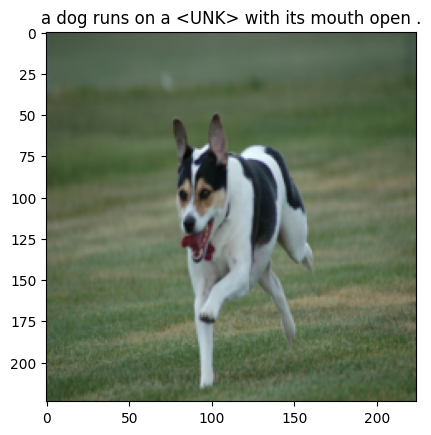

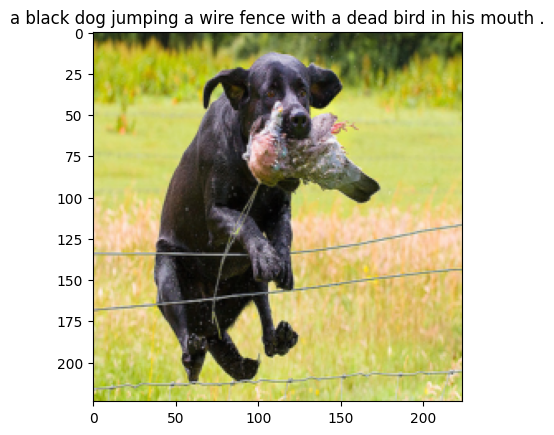

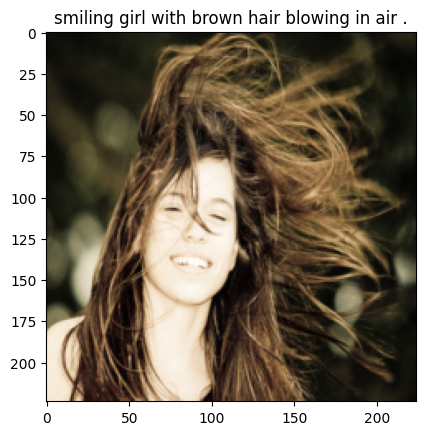

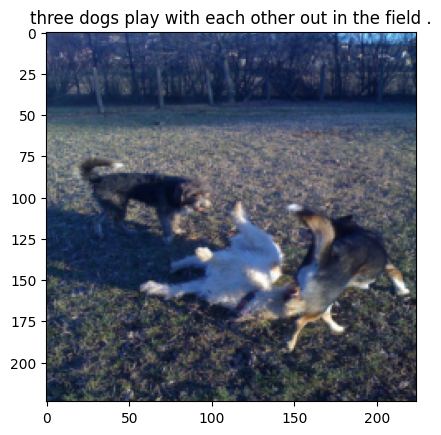

Process Process-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 334, in _exit_function
    _run_finalizers(0)
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
KeyboardInterrupt


In [31]:
#generating the iterator from the dataloader
dataiter = iter(data_loader)

#getting the next batch
batch = next(dataiter)

#unpacking the batch
images, captions = batch

#showing info of image in single batch
for i in range(BATCH_SIZE):
    img,cap = images[i],captions[i]
    caption_label = [dataset.vocab.itos[token] for token in cap.tolist()]
    eos_index = caption_label.index('<EOS>')
    caption_label = caption_label[1:eos_index]
    caption_label = ' '.join(caption_label)                      
    show_image(img,caption_label)
    plt.show();

# Some helper functions:
* Plot image 

In [39]:
def show_image(img, title = None):
    
    print(img.shape)
    # Un-normalize
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Module

In [64]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        for param in resnet.parameters():
            param.requires_grad = False 
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
    
    def forward(self, images):
        # (B, 2048, 7, 7)
        x = self.resnet(images)
        # (B, 2048, 7, 7) -> (B, 7, 7, 2048)
        x = x.permute(0, 2, 3, 1)
        # (B, 7, 7, 2048) -> (B, 49, 2048)
        x = x.view(x.size(0), -1, x.size(-1))
        
        return x

In [65]:
class Attention(nn.Module):
    def __init__(
        self, 
        encoder_dim,
        decoder_dim,
        attention_dim
    ):
        super().__init__()
        self.attention_dim = attention_dim
        self.W = nn.Linear(decoder_dim, attention_dim, bias=False)
        self.U = nn.Linear(encoder_dim, attention_dim, bias=False)
        self.A = nn.Linear(attention_dim, 1)
    
    def forward(self, features, hidden_state):
        # (B, 2048, E) -> (B, 2048, A)
        u_hs = self.U(features)
        # (B, D) -> (B, A)
        w_ah = self.W(hidden_state)
        
        
        combined_states = torch.tanh(u_hs + w_ah.unsqueeze(1))
        
        attention_scores = self.A(combined_states)
        attention_scores = attention_scores.squeeze(2)
        
        alpha = F.softmax(attention_scores, dim = 1)
        
        attention_weights = features * alpha.unsqueeze(2)
        attention_weights = attention_weights.sum(dim = 1) 
        
        return alpha, attention_weights 

In [107]:
class Decoder(nn.Module):
    def __init__(
        self,
        embed_size,
        vocab_size,
        attention_dim,
        encoder_dim,
        decoder_dim,
        p_dropout = 0.3
    ):
        super().__init__()
        
        self.vocab_size = vocab_size 
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)
        
        self.init_h = nn.Linear(encoder_dim,decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        
        self.lstm_cell = nn.LSTMCell(embed_size + encoder_dim, decoder_dim, bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        self.fcn = nn.Linear(decoder_dim, vocab_size)
        self.dropout = nn.Dropout(p_dropout)
    
    def forward(self, features, captions, device):
        """ 
        features: (B, 49, 2048),
        captions: (B, C)
        B: Batch size
        C: words in one captions
        E: embedding dimension
        D: decoder dimention
        """
        
        n_batchs = features.size(0)
        num_features = features.size(1)
        
        # (B, C, E)
        embeds = self.embedding(captions)
        
        # (B, D) , (B, D)
        h, c = self.init_hidden_state(features)
        
        # -1 because remove the the last one 
        seq_length = len(captions[0]) - 1
        
        
        preds = torch.zeros(n_batchs, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(n_batchs, seq_length, num_features).to(device)
        
        for s in range(seq_length):
            alpha, context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            
            output = self.fcn(self.dropout(h))
            
            preds[:, s] = output
            alphas[:, s] = alpha
        
        return preds, alphas
    
    def generate_caption(self, features, device, max_len=20, vocab=None):
        """ 
        features: (B, 49, 2048),
        """
        b_bactch = features.size(0)
        h, c = self.init_hidden_state(features)
        
        alphas = []
        
        # starting input 
        word = torch.tensor(vocab.stoi['<SOS>']).view(1, -1).to(deivce)
        embeds = self.embedding(word)
        
        captions = []
        
        for i in range(max_len):
            alpha, context = self.attention(features, h)
            
            # store the alpha score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(bacth_size, -1)
            
            # select the word with most val
            predcited_word_idx = output.argmax(dim = 1)
            captions.append(predcited_word_idx.item())
            
            # end if <EOS> detected
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            
            # send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
            
        
        return [vocab.itos[idx] for idx in captions],alphas
        
    
    def init_hidden_state(self, encoder_out):
        # (B, 49, 2048) -> (B, 2048)
        mean_encoder_out = encoder_out.mean(dim = 1)
        # (B, 2048) -> (B, D)
        h = self.init_h(mean_encoder_out)
        c = self.init_c(mean_encoder_out)
        return h, c

In [108]:
x = torch.rand((32, 20, 100))
x.size()

x.mean(dim = 1, keepdim=True).size()

torch.Size([32, 1, 100])

In [109]:
class Net(nn.Module):
    def __init__(
        self,
        embed_size,
        vocab_size,
        attention_dim,
        encoder_dim,
        decoder_dim,
        p_dropout = 0.3
    ):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(
            embed_size = embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim = attention_dim,
            encoder_dim = encoder_dim,
            decoder_dim = decoder_dim
        )
    
    def forward(self, images, captions, device):
        # (B, 49, 2048)
        features = self.encoder(images)
        outputs = self.decoder(features, captions, device)
        return outputs
        

# Train Model

In [ ]:
EMBED_SIZE = 300
ATTENTION_DIM = 256
ENCODER_DIM = 2048
DECODER_DIM = 512
LEARNING_RATE = 3e-4

In [95]:
model = Net(
    embed_size = EMBED_SIZE,
    vocab_size = len(dataset.vocab),
    attention_dim=ATTENTION_DIM,
    encoder_dim=ENCODER_DIM,
    decoder_dim=DECODER_DIM
)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
model = Net(
    embed_size = EMBED_SIZE,
    vocab_size = len(dataset.vocab),
    attention_dim=ATTENTION_DIM,
    encoder_dim=ENCODER_DIM,
    decoder_dim=DECODER_DIM
)
model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

num_epochs = 2
print_every = 100

for epoch in range(1,num_epochs+1):   
    for idx, (image, captions) in enumerate(data_loader):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions, device)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, len(dataset.vocab)), targets.reshape(-1))
        
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()

        if (idx+1)%print_every == 0:
            print("Epoch: {} loss: {:.5f}".format(epoch,loss.item()))
            
            
            #generate the caption
            model.eval()
            with torch.no_grad():
                dataiter = iter(data_loader)
                img,_ = next(dataiter)
                features = model.encoder(img[0:1].to(device))
                caps,alphas = model.decoder.generate_caption(features, device = device,vocab=dataset.vocab)
                caption = ' '.join(caps)
                show_image(img[0],title=caption)
                
            model.train()

NameError: name 'deivce' is not defined

# Visualizing the attentions